In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('../data/raw/star_classification.csv')

## Preliminary Data Analysis

### Repartition of the data by class

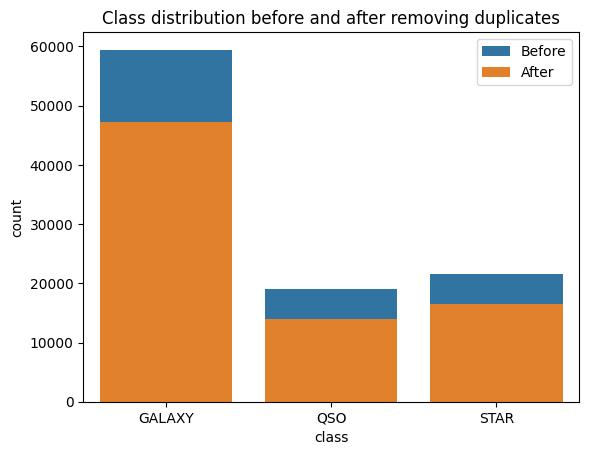

In [73]:
sns.countplot(x='class', data=df)
df = df.drop_duplicates(subset='obj_ID',keep='first')
df = df.drop(df[(df["class"] == "GALAXY") & (df["redshift"] == 0)].index)
sns.countplot(x='class', data=df)
plt.title('Class distribution before and after removing duplicates')
plt.legend(['Before','After'])

### Dealing with unwanted features

obj_ID, run_ID, camcol, field_ID, rerun_ID, plate, MJD, fiber_ID, spec_obj_id columns correspond to identifier of diverse measure equipment. We drop all this columns as they are not useful for our analysis. 

In [74]:
df=df.drop(['obj_ID','run_ID','rerun_ID','cam_col','field_ID','plate','MJD','fiber_ID','spec_obj_ID'], axis=1)

Alpha and Delta correspond to the coordinates of the object in the sky so we can drop them too as they are not useful for our analysis.

In [75]:
#drop the columns that are not relevant for the classification
df=df.drop(['alpha','delta'], axis=1)

### Visualizing the correlation between selected features

Text(0.5, 1.0, 'Correlation matrix')

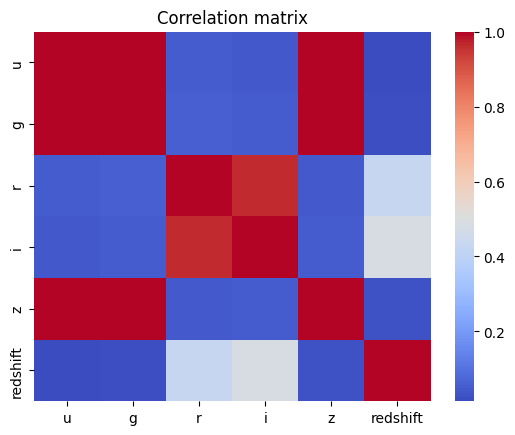

In [76]:
#correlation matrix
df_w = df.drop(['class'], axis=1)
corr = df_w.corr()
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('Correlation matrix')

### Visualizing the distribution of selected features

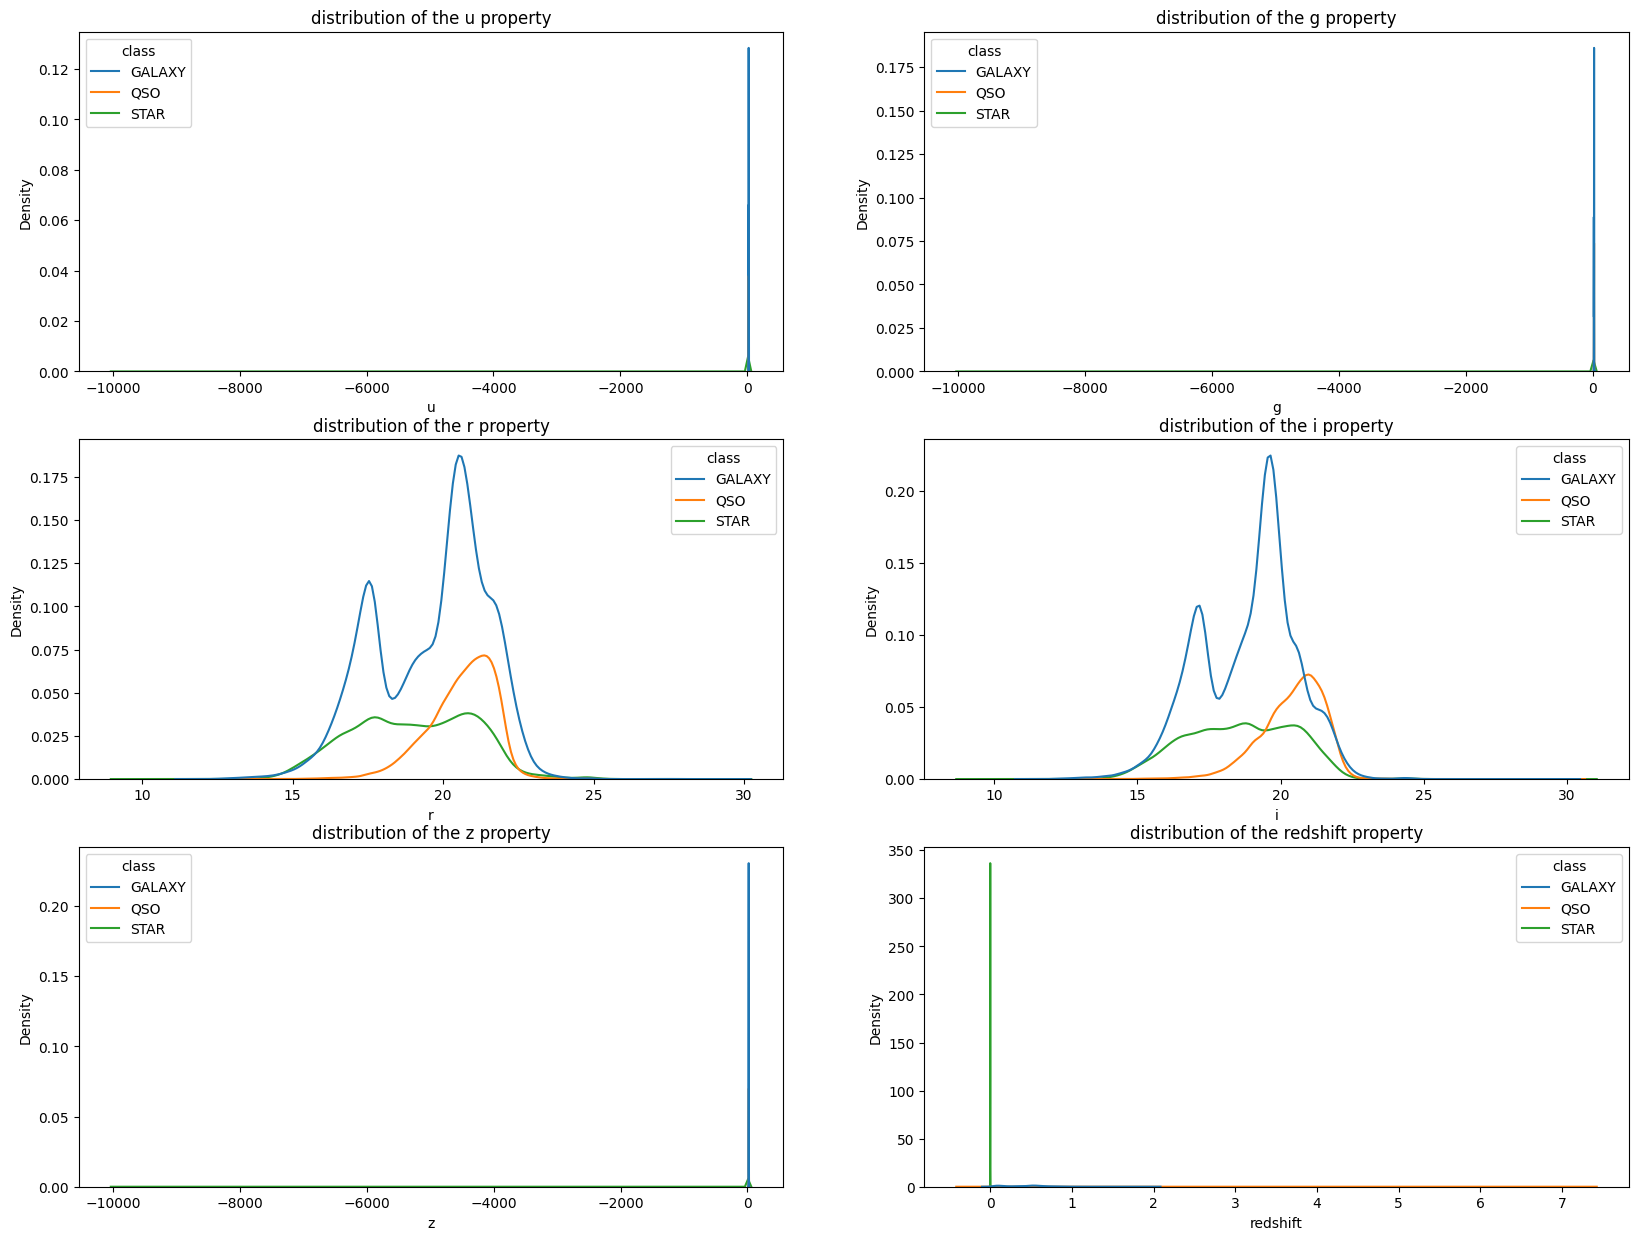

In [77]:
#data distribution
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
axes = axes.flatten()
for i,var in enumerate(df_w.columns[:]):
    sns.kdeplot(data=df, x=var, hue='class', ax=axes[i])
    axes[i].set_title("distribution of the "+ var+" property")


For g, z, u and redshift we can see some abnormal values, but we can't realy see well the distribution of the data. Let's try to plot the data in log scale.

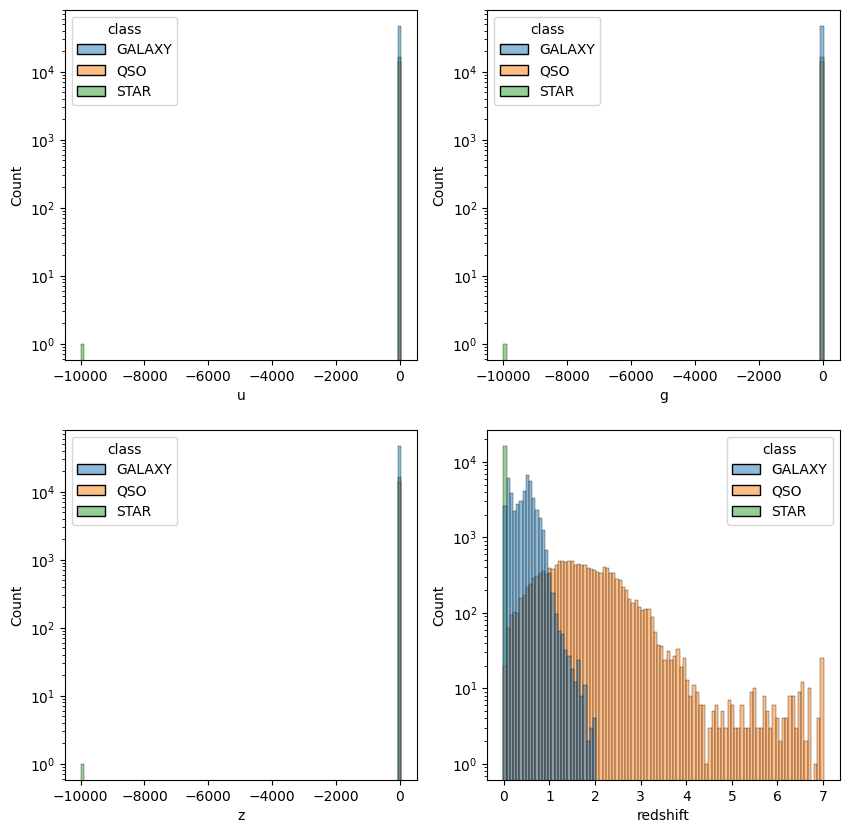

In [78]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

sns.histplot(data=df, x='u', hue='class', bins=100, ax=axes[0])
axes[0].set_yscale('log')
sns.histplot(data=df, x='g', hue='class', bins=100, ax=axes[1])
axes[1].set_yscale('log')
sns.histplot(data=df, x='z', hue='class', bins=100, ax=axes[2])
axes[2].set_yscale('log')
sns.histplot(data=df, x='redshift', hue='class', bins=100, ax=axes[3])
axes[3].set_yscale('log')


Almost every value in g, z and u are close to 0, exept for 1 point near -100000. Let's remove it. 

In [79]:
df = df[df['g'] > -2000]
df = df[df['z'] > -2000]
df = df[df['u'] > -2000]

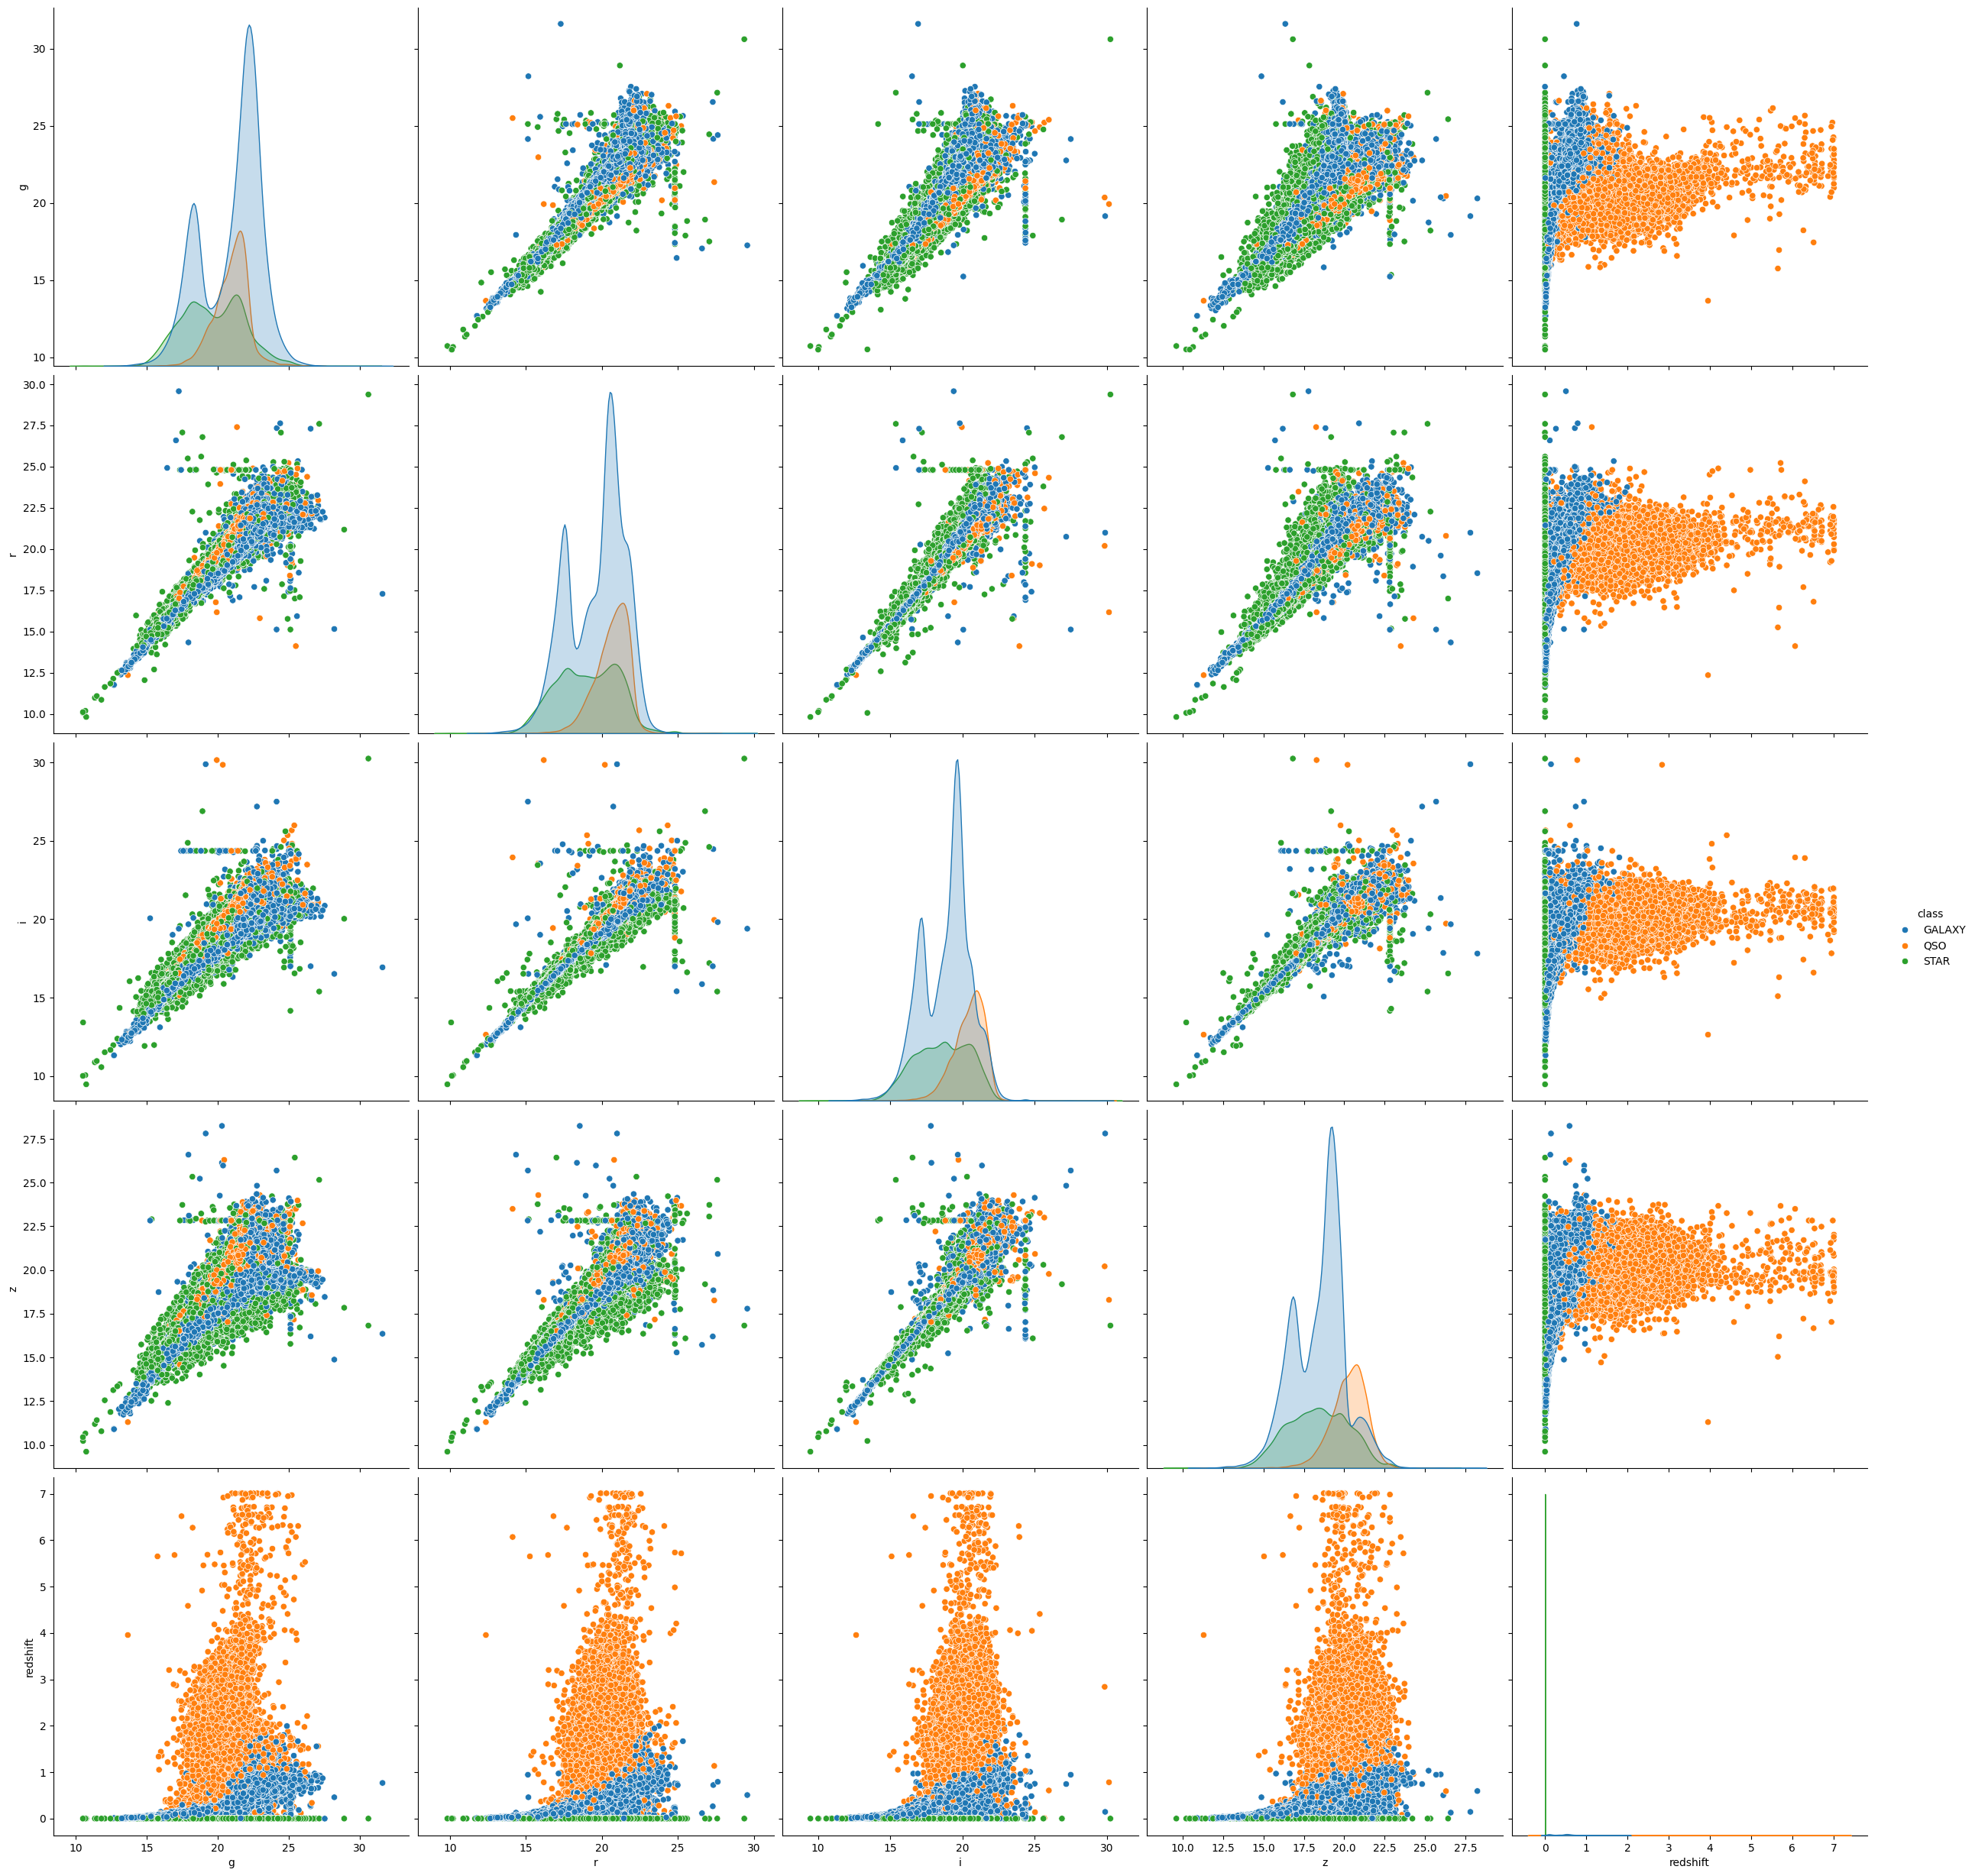

In [80]:
#show for each class the distribution of the features
sns.pairplot(df, hue='class', vars=['g','r','i','z','redshift'], height=5)


## Dealing with outliers

### Using UMAP to reduce the dimensionality of the data

In [81]:
data = df.drop(['class'], axis=1)
labels = df['class']

In [82]:
import umap
import umap.plot
reducer = umap.UMAP(set_op_mix_ratio=0.008).fit(data)

<Axes: >

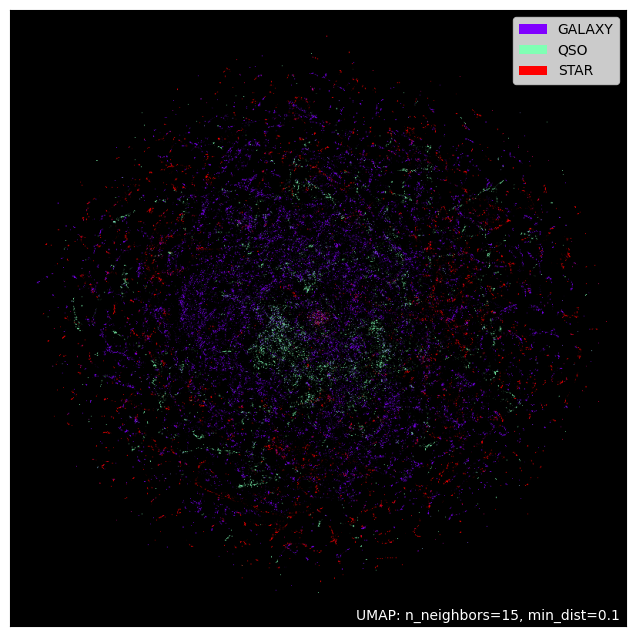

In [83]:
umap.plot.points(reducer, labels=labels, theme='fire')

### Detecting outliers using Local Outlier Factor

In [84]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope

outlier_scores_LOF = LocalOutlierFactor(contamination=0.04).fit_predict(reducer.embedding_)
outlying_object_LOF = data[outlier_scores_LOF == -1]
outlier_scores_EE = EllipticEnvelope(contamination=0.04).fit_predict(reducer.embedding_)
outlying_object_EE = data[outlier_scores_EE == -1]
outlier_scores_IF = IsolationForest(contamination=0.04).fit_predict(reducer.embedding_)
outlying_object_IF = data[outlier_scores_IF == -1]


We plot the data in by class with inliners in red and detected outliers in blue.

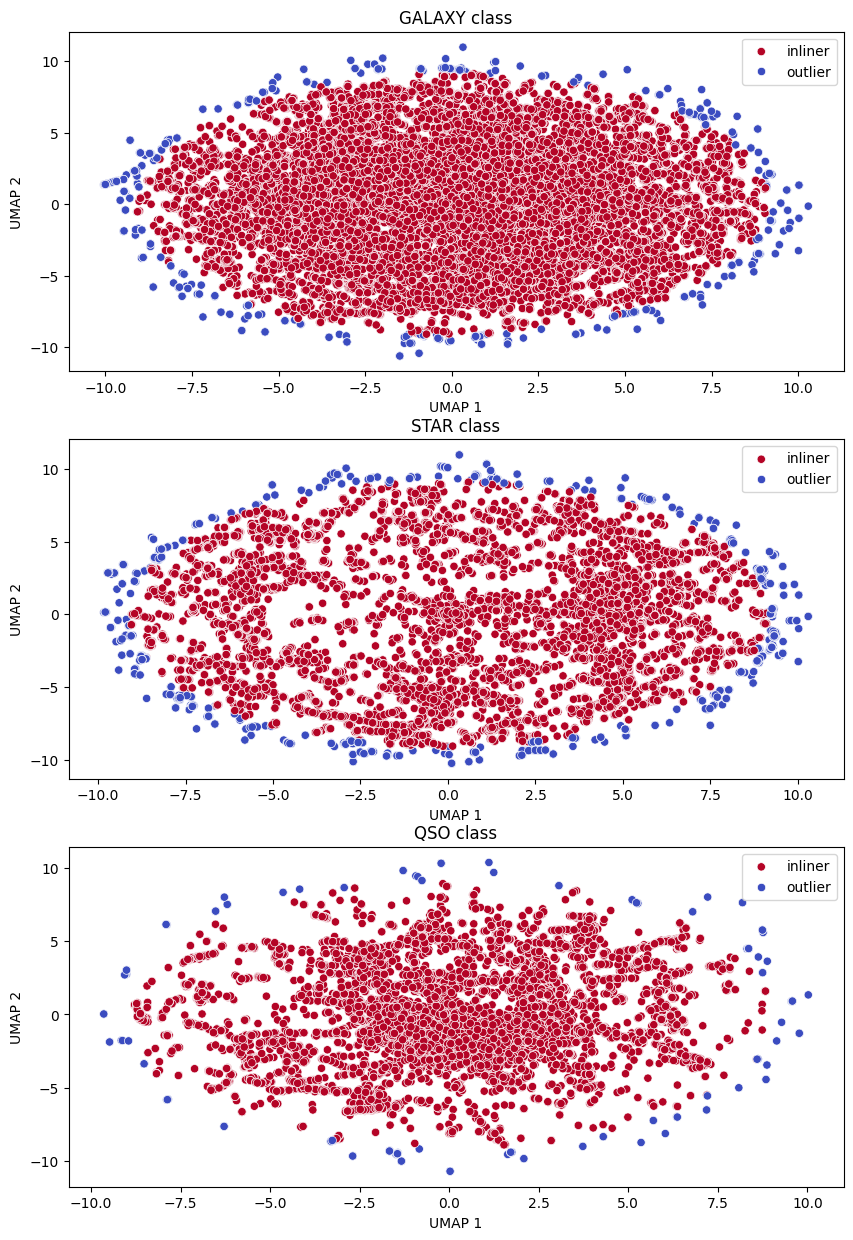

In [85]:
reducer_embedding = pd.DataFrame(reducer.embedding_)
labels = labels.reset_index(drop=True)
outlier_scores = pd.DataFrame(outlier_scores_EE)
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
axes = axes.flatten()
sns.scatterplot(data=reducer_embedding[labels=="GALAXY"], x=0, y=1, hue=outlier_scores[labels=="GALAXY"][0], palette='coolwarm', ax=axes[0])
axes[0].set_title("GALAXY class")
axes[0].set_xlabel("UMAP 1")
axes[0].set_ylabel("UMAP 2")
axes[0].legend(["inliner", "outlier"])

sns.scatterplot(data=reducer_embedding[labels=="STAR"], x=0, y=1, hue=outlier_scores[labels=="STAR"][0], palette='coolwarm', ax=axes[1])
axes[1].set_title("STAR class")
axes[1].set_xlabel("UMAP 1")
axes[1].set_ylabel("UMAP 2")
axes[1].legend(["inliner", "outlier"])


sns.scatterplot(data=reducer_embedding[labels=="QSO"], x=0, y=1, hue=outlier_scores[labels=="QSO"][0], palette='coolwarm', ax=axes[2])
axes[2].set_title("QSO class")
axes[2].set_xlabel("UMAP 1")
axes[2].set_ylabel("UMAP 2")
axes[2].legend(["inliner", "outlier"])

### Deleting outliers from the dataset

In [86]:
outlier_scores=pd.DataFrame(outlier_scores_EE).reset_index(drop=True)
data = data.reset_index(drop=True)
labels = labels.reset_index(drop=True)
data = data[outlier_scores[0] == 1]
labels = labels[outlier_scores[0] == 1]
data = data.reset_index(drop=True)
labels = labels.reset_index(drop=True)
#save the data into interim folder
data.to_csv('../data/interim/star_classification.csv', index=False)

In [87]:
data.to_csv('../data/interim/data.csv', index=False)
labels.to_csv('../data/interim/labels.csv', index=False)

## Preprocessing the data and Feature Engineering

### Splitting the data into train and test sets

In [88]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

### Feature Engineering with PCA

using UMAP to calculate the reducer and embedding of the train set

In [89]:
from sklearn.decomposition import PCA

group_ugriz = X_train[['u', 'g', 'r', 'i', 'z']]
pca = PCA(n_components=5).fit(group_ugriz)
pca_train = pd.DataFrame(pca.transform(group_ugriz), columns=['pca_ugriz_1', 'pca_ugriz_2', 'pca_ugriz_3', 'pca_ugriz_4', 'pca_ugriz_5'])
pca_test = pd.DataFrame(pca.transform(X_test[['u', 'g', 'r', 'i', 'z']]), columns=['pca_ugriz_1', 'pca_ugriz_2', 'pca_ugriz_3', 'pca_ugriz_4', 'pca_ugriz_5'])

In [90]:
data_train = pd.concat([pca_train, X_train["redshift"]], axis=1)
data_train = data_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
data_train.head()

pca_ugriz_1  pca_ugriz_2  pca_ugriz_3  pca_ugriz_4  pca_ugriz_5  redshift
0    -2.371145     1.571742    -0.143878     0.058246     0.058397  0.634794
1    -3.190284     0.209996     0.661730     0.346679     0.374921  0.779136
2    -4.231185    -2.536059    -1.678128     0.761961     0.317769  0.644195
3     4.885138    -2.106892     0.257844    -0.340618    -0.103042  0.932346
4     5.107057     0.665346    -0.235176     0.033875    -0.002945       NaN

### Scaling the data

we use robust scaler to scale the data

In [91]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler().fit(data_train)
data_train = scaler.transform(data_train)
data_train = pd.DataFrame(data_train)
data_train.columns = ['ugz_1','ugz_2','ugz_3','ri_1','ri_2','redshift']
data_train.head()

ugz_1     ugz_2     ugz_3      ri_1      ri_2  redshift
0 -0.210692  0.622197 -0.237309  0.318573  0.588998  0.276949
1 -0.351094  0.032866  1.240241  1.919580  3.621582  0.506583
2 -0.529506 -1.155560 -3.051248  4.224696  3.074014  0.291905
3  1.033051 -0.969827  0.499482 -1.895412 -0.957739  0.750323
4  1.071088  0.229931 -0.404757  0.183295  0.001285       NaN

## Visualizing final data

<Axes: >

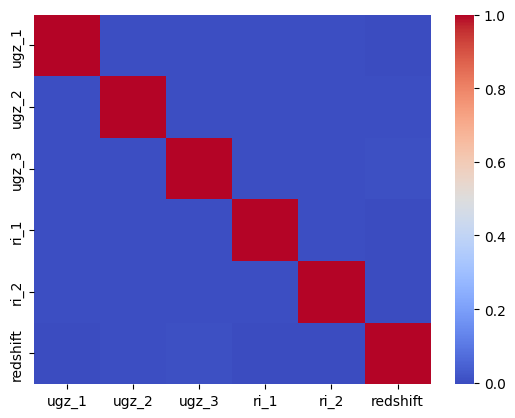

In [92]:
#correlation matrix
corr = data_train.corr()
sns.heatmap(corr, annot=False, cmap='coolwarm')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


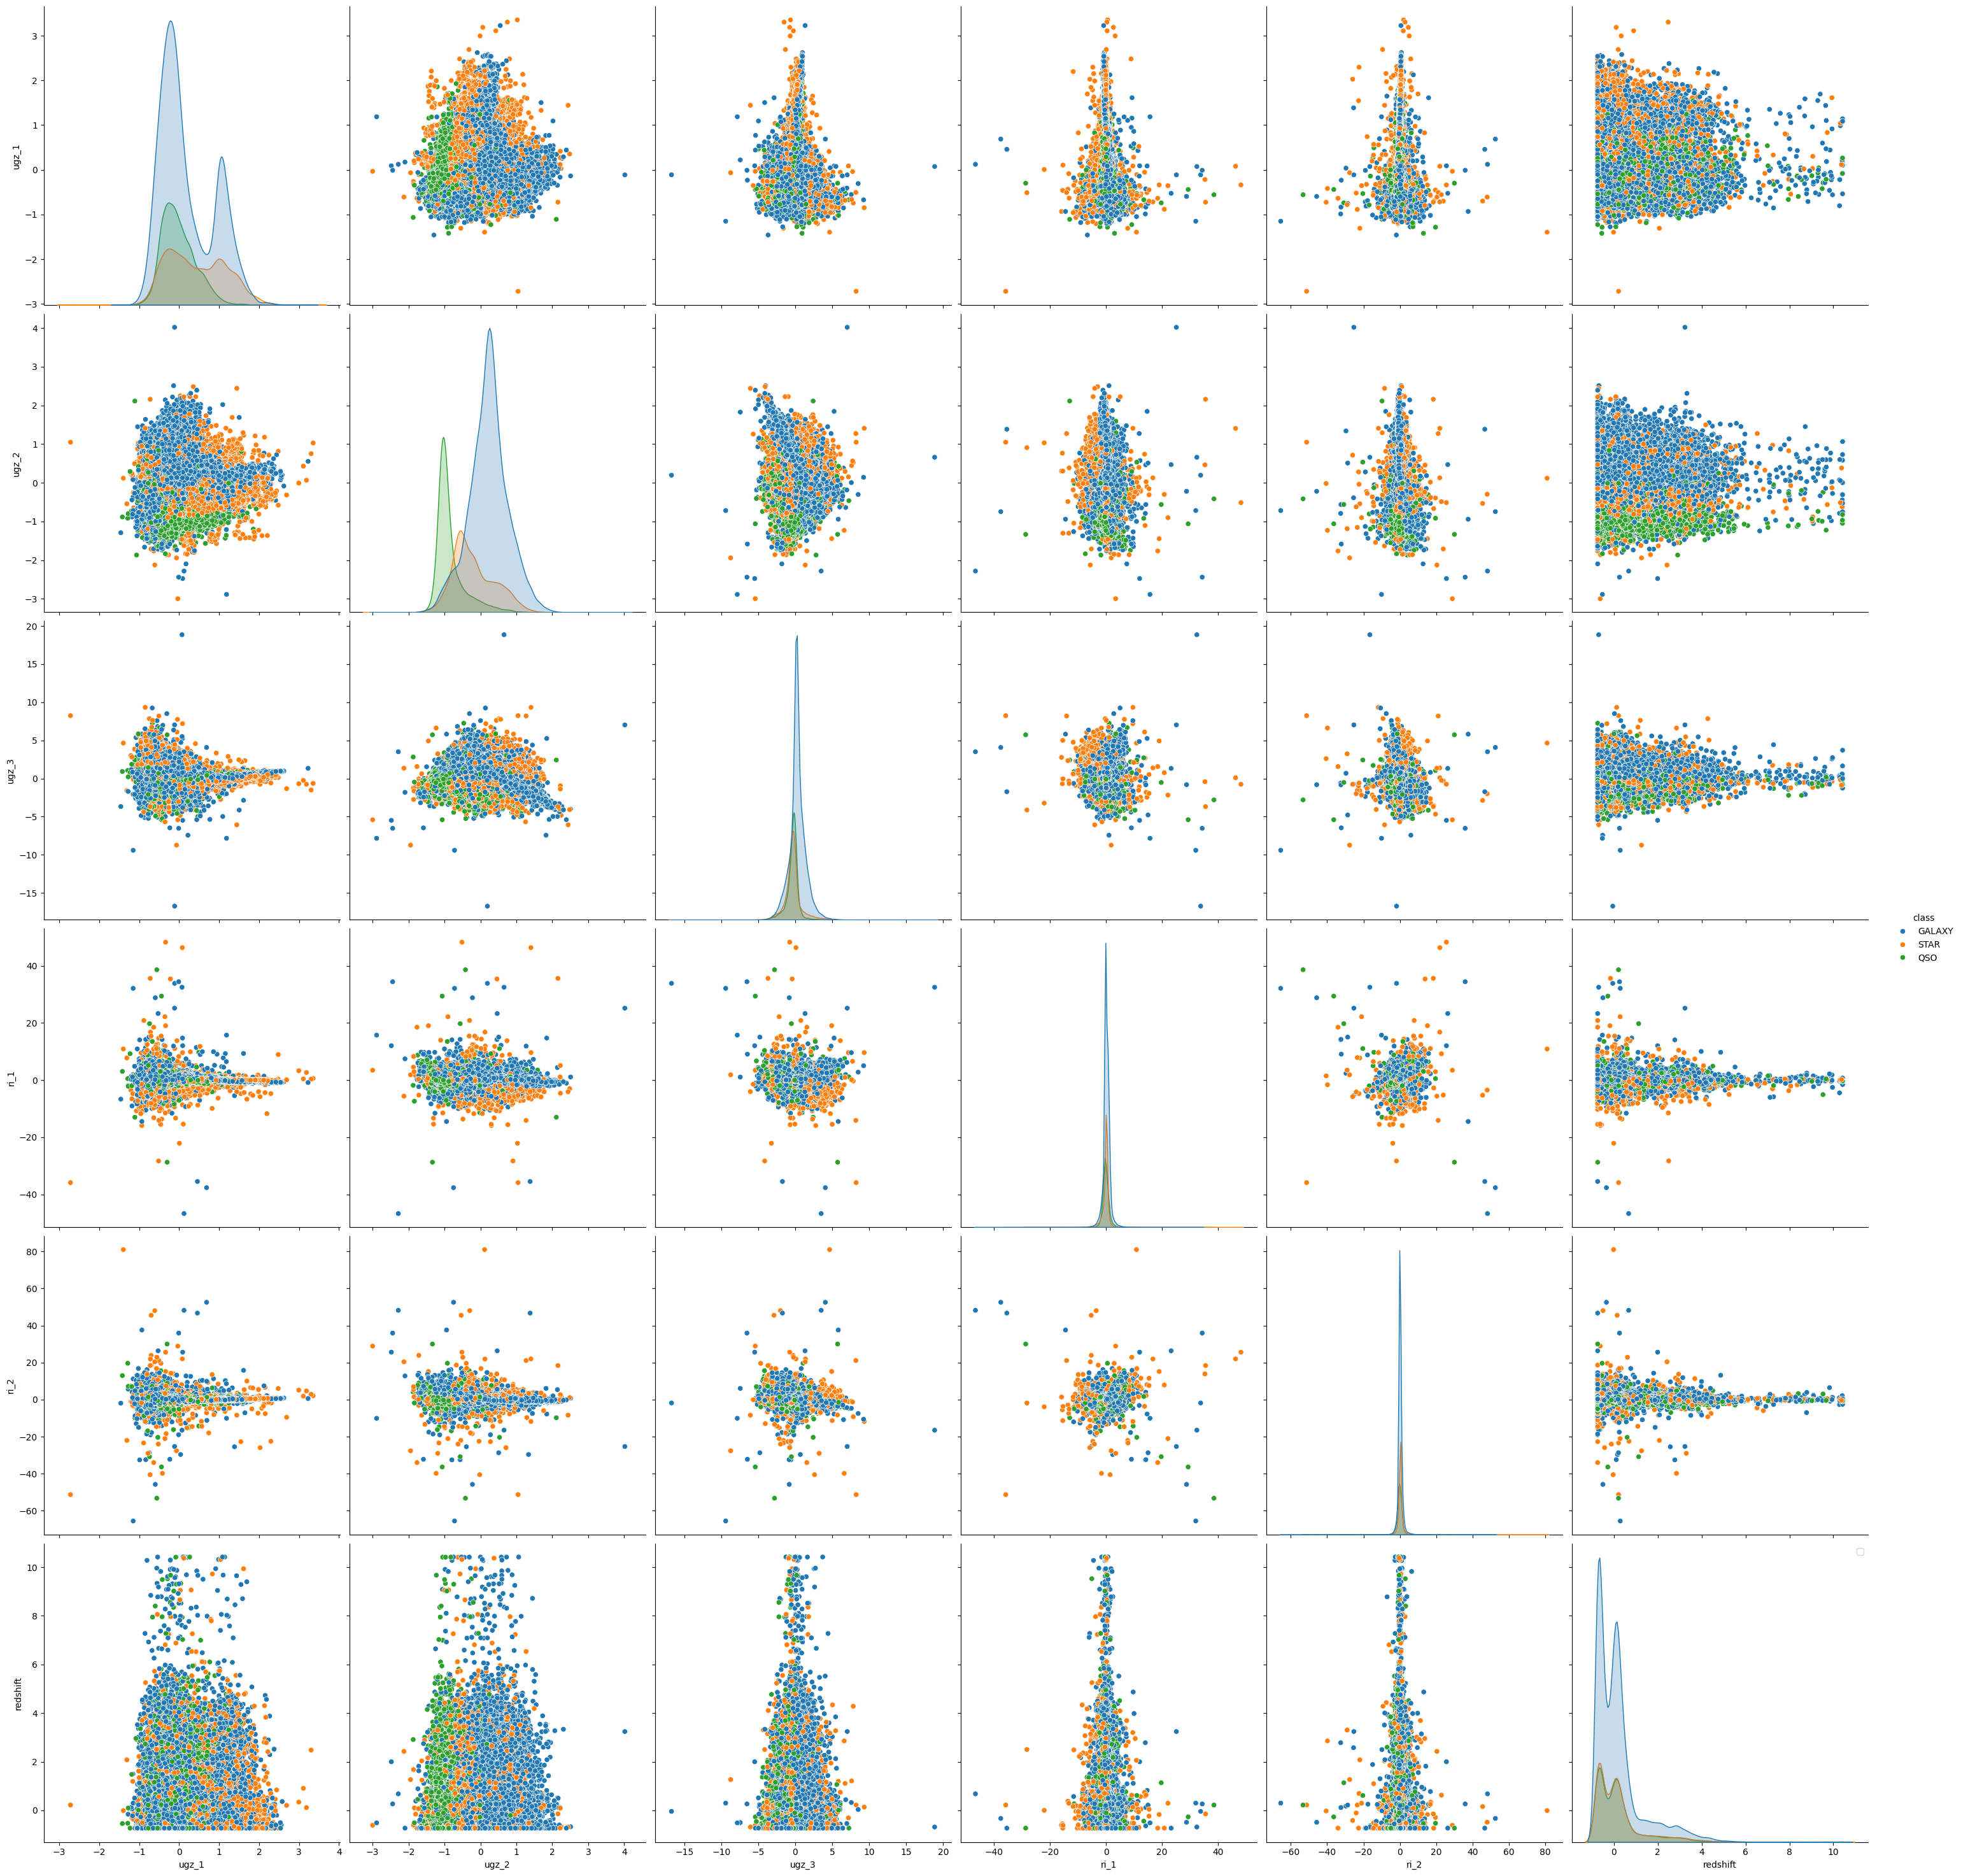

In [93]:
#pairplot
data_train['class'] = y_train
sns.pairplot(data_train, hue='class', vars=['ugz_1','ugz_2','ugz_3','ri_1','ri_2','redshift'], height=5)
plt.legend(loc='upper right')

With build features, we make 4 datasets. One processed (that was scaled), one reducted (Umap to remove correlation between features), one oversampled (with SMOTE) and one undersampled (with Clustercentering). We display theses 4 datasets 

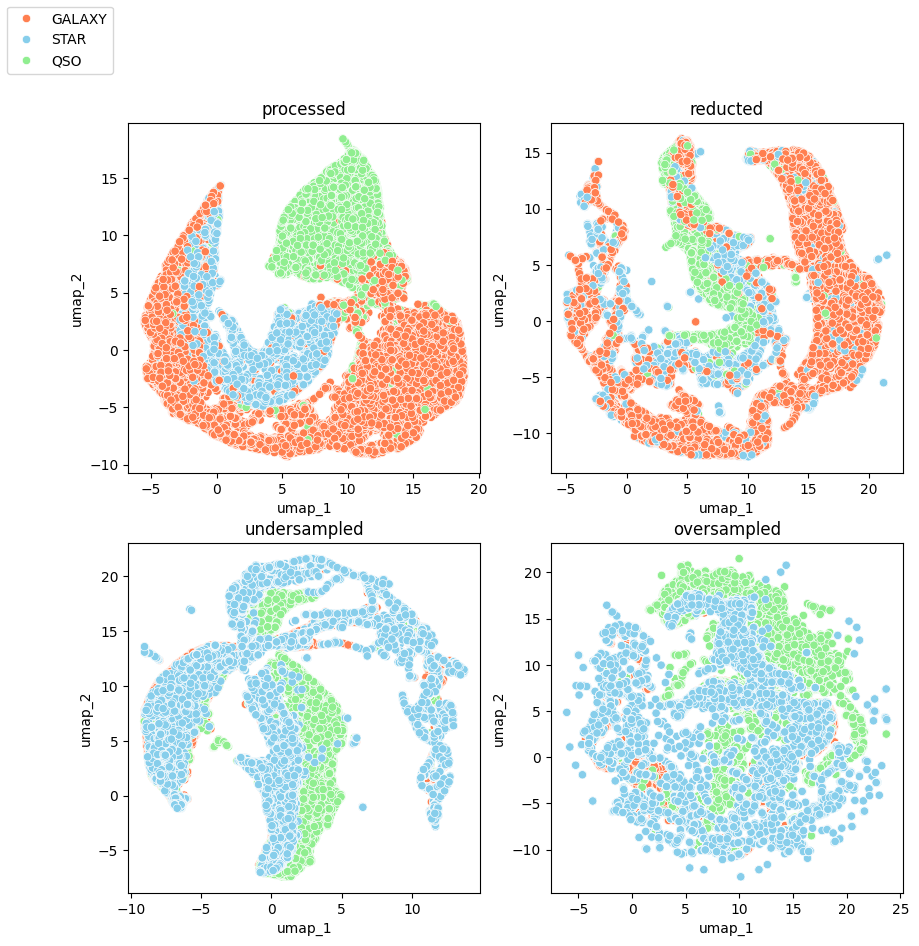

In [94]:
import umap
# Plot the 4 umap plots
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

class_colors = {
    "GALAXY": "coral",   
    "QSO": "lightgreen",      
    "STAR": "skyblue"    
}

for i, file in enumerate(['processed', 'reducted', 'undersampled', 'oversampled']):
    data_train = pd.read_csv(f'../data/processed/train_{file}.csv')
    X,y = data_train.drop(['class'], axis=1), data_train['class']
    # umap
    reducer = umap.UMAP().fit(X)
    embedding = pd.DataFrame(reducer.transform(X))
    embedding['class'] = y
    embedding.columns = ['umap_1','umap_2','class']
    sns.scatterplot(data=embedding, x='umap_1', y='umap_2', hue='class', palette=class_colors, ax=axes[i])
    axes[i].set_title(file)
    axes[i].legend_.remove()

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left')


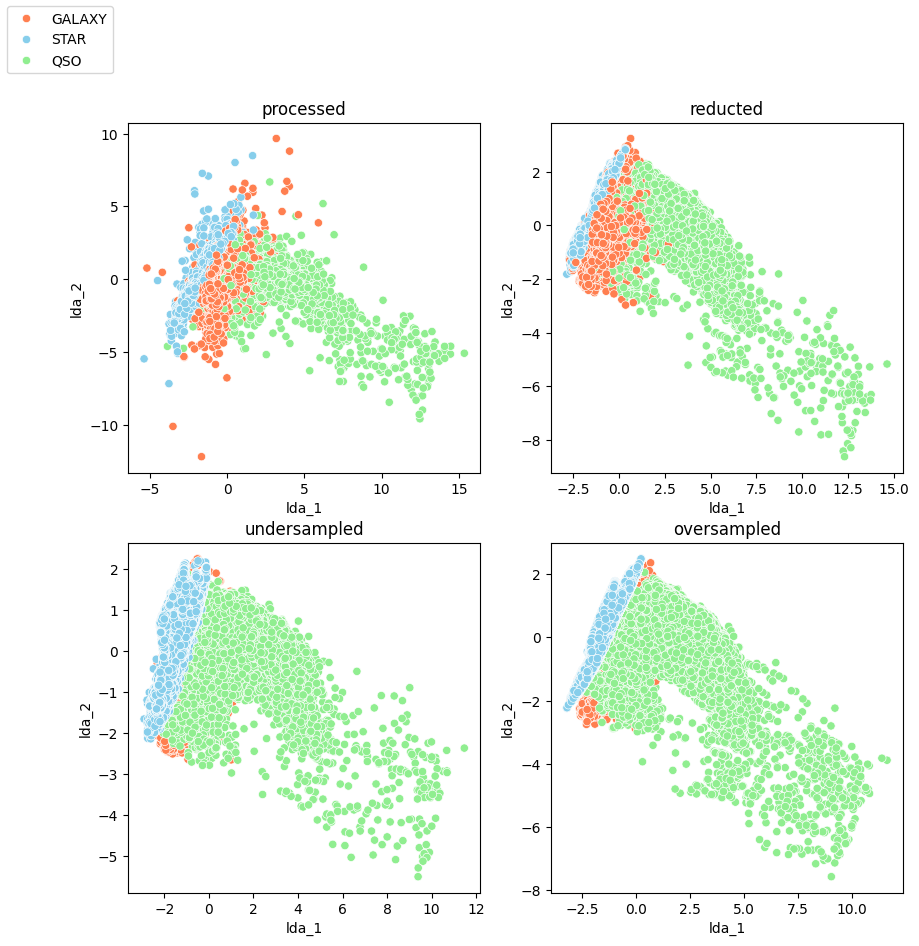

In [95]:
# LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#Plot the 4 LDA plots
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

class_colors = {
    "GALAXY": "coral",   # A cooler/lighter shade of red
    "QSO": "lightgreen",      # A cooler/lighter shade of green
    "STAR": "skyblue"    # A cooler/lighter shade of blue
}

for i, file in enumerate(['processed', 'reducted', 'undersampled', 'oversampled']):
    data_train = pd.read_csv(f'../data/processed/train_{file}.csv')
    X,y = data_train.drop(['class'], axis=1), data_train['class']
    # LDA
    reducer = LinearDiscriminantAnalysis(n_components=2).fit(X,y)
    embedding = pd.DataFrame(reducer.transform(X))
    embedding['class'] = y
    embedding.columns = ['lda_1','lda_2','class']
    sns.scatterplot(data=embedding, x='lda_1', y='lda_2', hue='class', palette=class_colors, ax=axes[i])
    axes[i].set_title(file)
    axes[i].legend_.remove()

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left')

<Axes: >

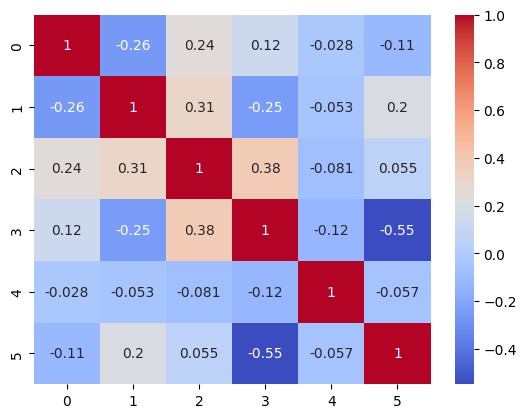

In [96]:
data = pd.read_csv('../data/processed/train_processed.csv')

X,y = data.drop(['class'], axis=1), data['class']

reducer = umap.UMAP(n_components=6).fit(X)
embedding = pd.DataFrame(reducer.transform(X))

corr = embedding.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')



<Axes: xlabel='umap_1', ylabel='umap_2'>

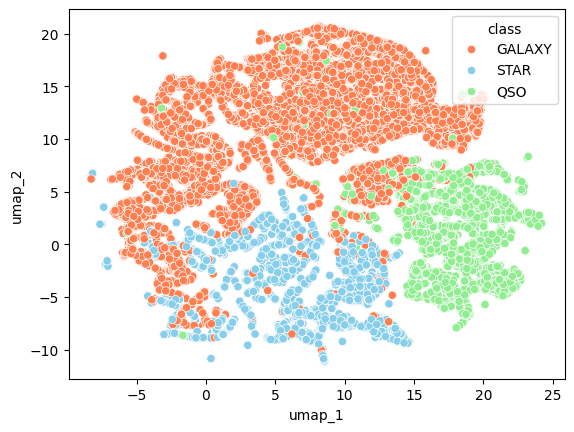

In [97]:
reducer = umap.UMAP().fit(embedding)
embedding = pd.DataFrame(reducer.transform(embedding))
embedding['class'] = y
embedding.columns = ['umap_1','umap_2','class']

class_colors = {
    "GALAXY": "coral",   
    "QSO": "lightgreen",      
    "STAR": "skyblue"   
}

sns.scatterplot(data=embedding, x='umap_1', y='umap_2', hue='class', palette=class_colors)


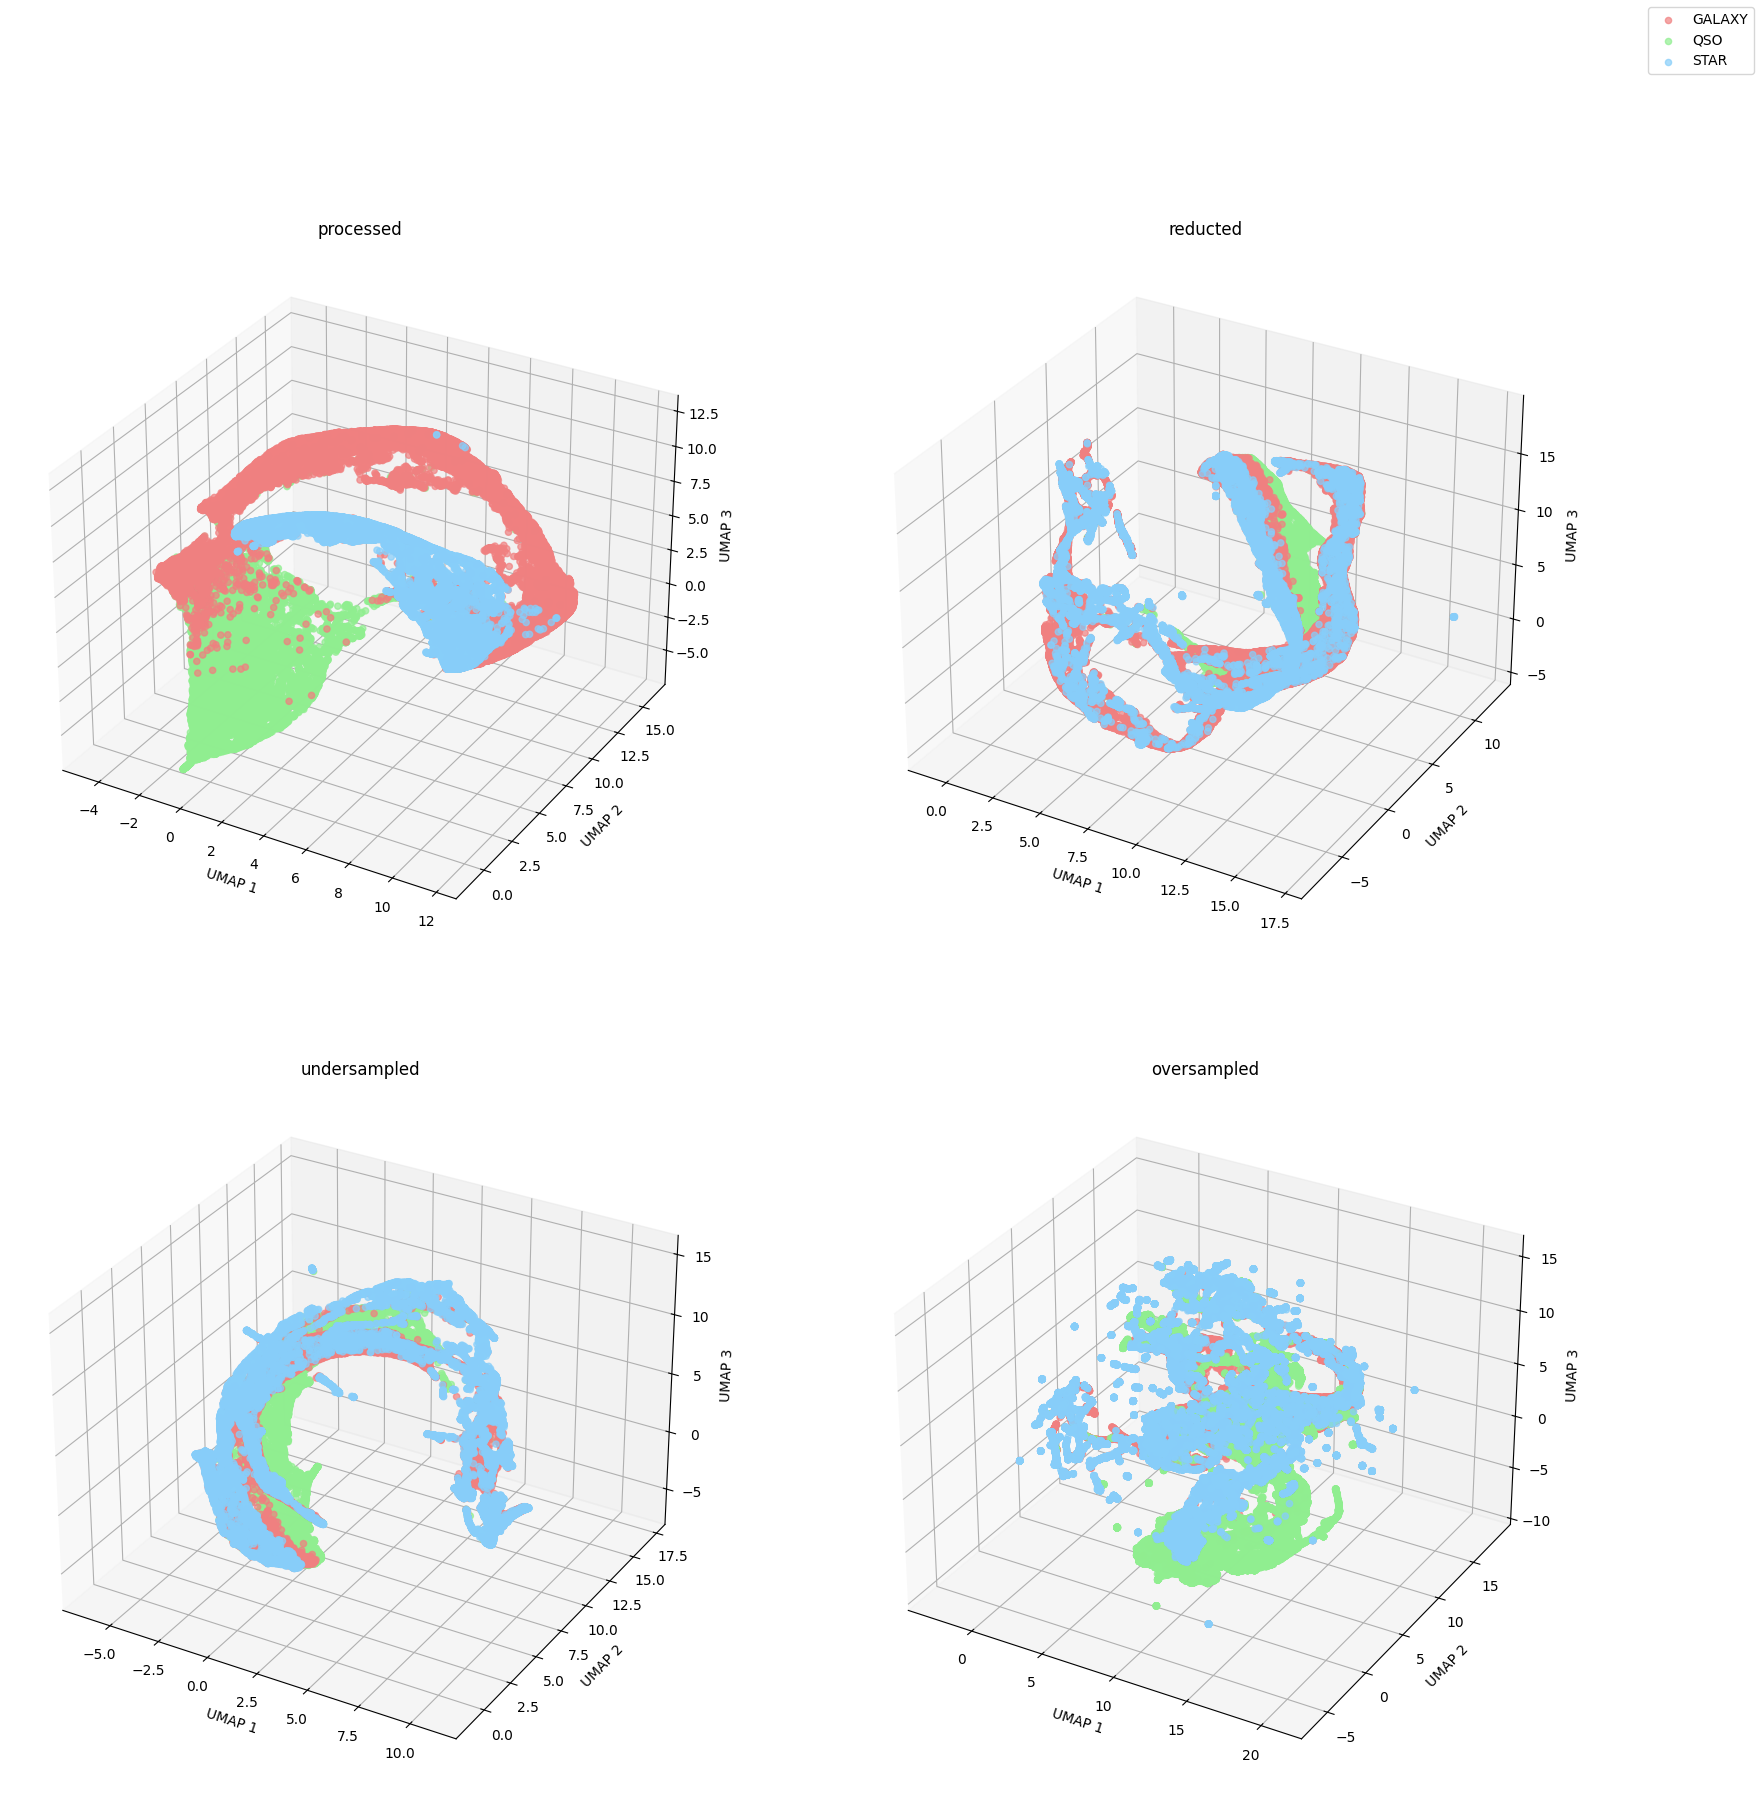

In [98]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd
import umap

# Define color palette
class_colors = {
    "GALAXY": "lightcoral",
    "QSO": "lightgreen",
    "STAR": "lightskyblue"
}

# Initialize a 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(20, 20), subplot_kw={'projection': '3d'})
axes = axes.flatten()

for i, file in enumerate(['processed', 'reducted', 'undersampled', 'oversampled']):
    data_train = pd.read_csv(f'../data/processed/train_{file}.csv')
    X, y = data_train.drop(['class'], axis=1), data_train['class']

    # UMAP with 3 components
    reducer = umap.UMAP(n_components=3).fit(X)
    embedding = pd.DataFrame(reducer.transform(X), columns=['umap_1', 'umap_2', 'umap_3'])
    embedding['class'] = y

    # 3D scatter plot
    ax = axes[i]
    for class_name, color in class_colors.items():
        class_data = embedding[embedding['class'] == class_name]
        ax.scatter(class_data['umap_1'], class_data['umap_2'], class_data['umap_3'], 
                   color=color, label=class_name, alpha=0.7)

    ax.set_title(file)
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.set_zlabel('UMAP 3')

# Create a single legend outside the subplots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

plt.show()
